In [1]:
import numpy as np
import librosa
import librosa.display
from python_speech_features import mfcc
from scipy.io import wavfile
import matplotlib.pyplot as plt
import hmmlearn
from sklearn import metrics
from sklearn.metrics import classification_report
import os
from pydub import AudioSegment
from scipy.stats import multivariate_normal

C:\Users\Mohammad Reza\AppData\Roaming\Python\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)
        
        for t in range(T):
            if t == 0:
                alpha[:,t] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf (obs.T, mean = self.mean[:, s], cov = self.covariances[:, :, s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood (obs)

        log_likelihood, alpha = self._forward (B)
        beta = self._backward (B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, -1] * beta[:, -1] 
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape (gamma[:, 0], (-1, 1))
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [5]:
hmm_models = []

classes = ["blues", "hiphop", "metal", "pop"]

data = np.array ([])
for i in range (len (classes)):
    d = "data2/" + classes[i]
    
    for file in os.listdir(d):
        name = d + "/" + file
        f, a = wavfile.read (name)
        m = mfcc (a, f)
        m = m / np.amax (m)
        
        if (len (data) == 0):
            data = m
        else:
            data = np.append (data, m, axis = 0)
            
    model = HMM (4)
    model.train (data.T)
    hmm_models.append ([model, classes[i]])
    model = None

In [6]:
r = []
p = []
model = None
for i in range (len (classes)):
    d = "data3/" + classes[i]
    for file in os.listdir(d):
        name = d + "/" + file
        f, a = wavfile.read (name)
        m = mfcc (a, f)
        m = m / np.amax (m)
        
        max_score = float ("-inf")
        for j in range (len(hmm_models)):
            model, g = hmm_models[j]
            score = model.score (m.T)
            if (max_score < score):
                max_score = score
                result = g
        r.append (classes[i])
        p.append (result)

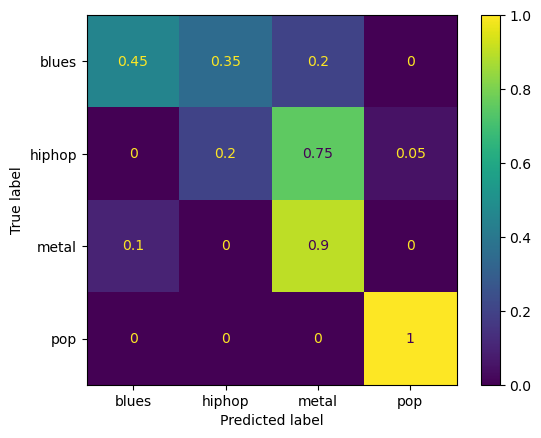

In [9]:
confusion_matrix = metrics.confusion_matrix(r, p)

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

cm_plot = metrics.ConfusionMatrixDisplay (confusion_matrix = confusion_matrix, display_labels = classes)

cm_plot.plot()
plt.show()

In [8]:
print(classification_report(r, p, target_names = classes))

              precision    recall  f1-score   support

       blues       0.82      0.45      0.58        20
      hiphop       0.36      0.20      0.26        20
       metal       0.49      0.90      0.63        20
         pop       0.95      1.00      0.98        20

    accuracy                           0.64        80
   macro avg       0.66      0.64      0.61        80
weighted avg       0.66      0.64      0.61        80



For better analyze we should consider f1-score and precision or recall is not enough.